In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Union, Tuple
import copy
from scipy.stats import multivariate_normal
from types import SimpleNamespace
import math
from das.smc_utils import compute_ess_from_log_w, normalize_log_weights, resampling_function, normalize_weights, adaptive_tempering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Define Functions and Classes for Diffusion

In [2]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),  # 2D input + time
            nn.ReLU(),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            # nn.Linear(128, 64),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 2D output
        )

    def forward(self, x, t):
        x = torch.cat([x, t.unsqueeze(-1)], dim=-1)
        return self.net(x)

In [3]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

class DDIMScheduler:
    def __init__(self, num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_train_timesteps = num_train_timesteps
        
        self.betas = linear_beta_schedule(num_train_timesteps, beta_start, beta_end).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        self.final_alpha_cumprod = self.alphas_cumprod[0]
        self.num_inference_steps = None
        
    def set_timesteps(self, num_inference_steps):
        self.num_inference_steps = num_inference_steps
        self.timesteps = torch.linspace(self.num_train_timesteps - 1, 0, num_inference_steps, dtype=torch.long)
        
    def _get_variance(self, timestep, prev_timestep):
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = torch.where(
            prev_timestep >= 0,
            self.alphas_cumprod[prev_timestep],
            self.final_alpha_cumprod
        )
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        
        variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
        return variance

In [4]:
def ddim_step_with_logprob(
    scheduler,
    model_output: torch.FloatTensor,
    timestep: int,
    sample: torch.FloatTensor,
    eta: float = 0.0,
    prev_sample: Optional[torch.FloatTensor] = None,
) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    """
    Perform a single DDIM step with log probability calculation.
    
    Args:
        scheduler: The DDIMScheduler object.
        model_output: The output from the UNet model.
        timestep: The current timestep.
        sample: The current sample (x_t).
        eta: The eta parameter for adding noise (0 for DDIM, 1 for DDPM).
        prev_sample: Optional; the previous sample (x_{t-1}) if available.
    
    Returns:
        A tuple containing:
        - The previous sample (x_{t-1})
        - The log probability of the step
    """
    # 1. get previous step value (=t-1)
    prev_timestep = timestep - scheduler.num_train_timesteps // scheduler.num_inference_steps

    # 2. compute alphas, betas
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = torch.where(
        prev_timestep >= 0,
        scheduler.alphas_cumprod[prev_timestep],
        scheduler.final_alpha_cumprod
    )

    beta_prod_t = 1 - alpha_prod_t

    # 3. compute predicted original sample from predicted noise
    pred_original_sample = (sample - beta_prod_t.sqrt().unsqueeze(-1) * model_output) / alpha_prod_t.sqrt().unsqueeze(-1)
    
    # 4. compute variance
    variance = scheduler._get_variance(timestep, prev_timestep)
    std_dev_t = eta * variance.sqrt()

    # 5. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/fontsize10.02502.pdf
    pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt().unsqueeze(-1) * model_output

    # 6. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    prev_sample_mean = alpha_prod_t_prev.sqrt().unsqueeze(-1) * pred_original_sample + pred_sample_direction

    # 6. Add noise
    if prev_sample is None:
        noise = torch.randn(model_output.shape, device=device, dtype=model_output.dtype)
        prev_sample = prev_sample_mean + std_dev_t.unsqueeze(-1) * noise
    
    # 7. Compute log probability
    log_prob = _compute_gaussian_log_prob(prev_sample, prev_sample_mean, std_dev_t.unsqueeze(-1)).mean(-1)

    return prev_sample, log_prob

def _compute_gaussian_log_prob(x, mean, std):
    """Compute log probability for Gaussian distribution."""
    log_scale = torch.log(std)
    return -((x - mean) ** 2) / (2 * std ** 2) - log_scale - math.log(math.sqrt(2 * math.pi))

In [5]:
def ddim_step_KL(
    scheduler: DDIMScheduler,
    model_output: torch.FloatTensor,
    old_model_output: torch.FloatTensor,
    timestep: torch.LongTensor,
    sample: torch.FloatTensor,
    eta: float = 0.0,
    generator=None,
    variance_noise: Optional[torch.FloatTensor] = None,
) -> Union[Tuple[torch.FloatTensor, torch.FloatTensor], Tuple]:
    
    # 1. get previous step value (=t-1)
    prev_timestep = timestep - scheduler.num_train_timesteps // scheduler.num_inference_steps

    # 2. compute alphas, betas
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = torch.where(
        prev_timestep >= 0,
        scheduler.alphas_cumprod[prev_timestep],
        scheduler.final_alpha_cumprod
    )

    beta_prod_t = 1 - alpha_prod_t

    # 3. compute predicted original sample from predicted noise
    pred_original_sample = (sample - beta_prod_t.sqrt().unsqueeze(-1) * model_output) / alpha_prod_t.sqrt().unsqueeze(-1)
    old_pred_original_sample = (sample - beta_prod_t.sqrt().unsqueeze(-1) * old_model_output) / alpha_prod_t.sqrt().unsqueeze(-1)

    # 4. compute variance
    variance = scheduler._get_variance(timestep, prev_timestep)
    std_dev_t = eta * variance.sqrt()

    # 5. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt().unsqueeze(-1) * model_output
    old_pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt().unsqueeze(-1) * old_model_output

    # 6. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    prev_sample_mean = alpha_prod_t_prev.sqrt().unsqueeze(-1) * pred_original_sample + pred_sample_direction
    old_prev_sample_mean = alpha_prod_t_prev.sqrt().unsqueeze(-1) * old_pred_original_sample + old_pred_sample_direction

    if eta > 0 and timestep[0] > 0:
        device = model_output.device
        noise = torch.randn(model_output.shape, generator=generator, device=device, dtype=model_output.dtype)
        variance = std_dev_t.unsqueeze(-1) * noise

        prev_sample = prev_sample_mean + variance
        # print((prev_sample_mean - old_prev_sample_mean))
        kl_terms = (prev_sample_mean - old_prev_sample_mean)**2 / (2 * (std_dev_t**2).unsqueeze(-1))
        kl_terms = kl_terms.sum(dim=-1)  # Sum over the 2D dimensions
        # print(kl_terms)
    else:
        prev_sample = prev_sample_mean
        kl_terms = torch.zeros(prev_sample_mean.size(0), device=prev_sample_mean.device)

    # 7. Compute log probability
    log_prob = _compute_gaussian_log_prob(prev_sample, prev_sample_mean, std_dev_t.unsqueeze(-1)).mean(-1)

    return prev_sample, log_prob, kl_terms

In [6]:
@torch.no_grad()
def ddim_sample(model, scheduler, n, device, eta=1.0):
    x = torch.randn((n, 2)).to(device)
    
    for i, t in enumerate(scheduler.timesteps):
        t_tensor = torch.full((n,), scheduler.timesteps[i], device=device) # torch.full((n,), t, device=device).long()
        model_output = model(x, t_tensor / scheduler.num_train_timesteps)
        x, _, _ = ddim_step_KL(scheduler, model_output, 0., t_tensor, x, eta)
    
    return x

## Define Data Distribution (Mixture of Gaussians)

In [7]:
# Generate data from mixture of 2D Gaussians
def sample_gaussian_mixture(n_samples, means, covs):
    n_gaussians = len(means)
    samples = []
    for _ in range(n_samples):
        idx = np.random.randint(0, n_gaussians)
        sample = np.random.multivariate_normal(means[idx], covs[idx])
        samples.append(sample)
    return np.array(samples)

n_samples = 100000
# means = [(-2, -2), (2, 2), (-2, 2), (2, -2)]
# means = [(-3, 0), (3, 0), (-3, -3), (3, -3), (-3, 3), (3, 3)]
# means = [(-2, 6), (2, 6), (-2, -2), (2, 2), (-2, 2), (2, -2), (-2, -6), (2, -6)]
means = [
    (-4, 4), (0, 4), (4, 4),
    (-4, 0), (0, 0), (4, 0),
    (-4, -4), (0, -4), (4, -4),
]
# means = [
#     (-6, 6), (-2, 6), (2, 6), (6, 6),
#     (-6, 2), (-2, 2), (2, 2), (6, 2),
#     (-6, -2), (-2, -2), (2, -2), (6, -2),
#     (-6, -6), (-2, -6), (2, -6), (6, -6),
# ]
# # means = [
#     (-4, 0), (-2*math.sqrt(2), 2*math.sqrt(2)), (0, 4), (2*math.sqrt(2), 2*math.sqrt(2)),
#     (4, 0), (2*math.sqrt(2), -2*math.sqrt(2)), (0, -4), (-2*math.sqrt(2), -2*math.sqrt(2)),
# ]
# means = [
#     (-6, 0), (-3*math.sqrt(3), 3), (-3, 3*math.sqrt(3)),
#     (0, 6), (3, 3*math.sqrt(3)), (3*math.sqrt(3), 3),
#     (6, 0), (3*math.sqrt(3), -3), (3, -3*math.sqrt(3)),
#     (0, -6), (-3, -3*math.sqrt(3)), (-3*math.sqrt(3), -3),
# ]
covs = [[[0.3, 0], [0, 0.3]] for _ in range(len(means))]
data = sample_gaussian_mixture(n_samples, means, covs)
data = torch.FloatTensor(data).to(device)

## Pre-training

In [8]:
# Hyperparameters
num_train_timesteps = 1000

# Initialize scheduler
scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps, device=device)

# Initialize models and optimizer
pre_trained_model = SimpleUNet().to(device)
optimizer = optim.Adam(pre_trained_model.parameters(), lr=1e-3)

In [9]:
# Pre-training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    t = torch.randint(0, num_train_timesteps, (n_samples,), device=device).long()
    noise = torch.randn_like(data)
    noisy_data = scheduler.alphas_cumprod[t].sqrt().unsqueeze(-1) * data + \
                 (1 - scheduler.alphas_cumprod[t]).sqrt().unsqueeze(-1) * noise
    predicted_noise = pre_trained_model(noisy_data, t.float() / num_train_timesteps)
    loss = F.mse_loss(predicted_noise, noise)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Pre-training Epoch {epoch}, Loss: {loss.item()}")

Pre-training Epoch 0, Loss: 1.037307620048523
Pre-training Epoch 100, Loss: 0.5717630386352539
Pre-training Epoch 200, Loss: 0.49397990107536316
Pre-training Epoch 300, Loss: 0.44605353474617004
Pre-training Epoch 400, Loss: 0.43227455019950867
Pre-training Epoch 500, Loss: 0.4144306182861328
Pre-training Epoch 600, Loss: 0.41487398743629456
Pre-training Epoch 700, Loss: 0.4084305763244629
Pre-training Epoch 800, Loss: 0.40634748339653015
Pre-training Epoch 900, Loss: 0.40500178933143616


In [10]:
# Set the number of inference steps before fine-tuning and sampling
num_inference_steps = 100
scheduler.set_timesteps(num_inference_steps)

## Define Reward, KL penalty coefficient, and Corresponding Target Distribution

In [11]:
def compute_reward(x):
    if isinstance(x, torch.Tensor):
        x_squared = torch.clamp(x**2, max=10000)
        return - x_squared[:, 0] / 100 - x_squared[:, 1]
    else:
        x_squared = x**2
        x_squared = np.where(x_squared > 10000, 10000, x_squared)
        return - x_squared[:, 0] / 100 - x_squared[:, 1]

kl_weight = 1.

In [12]:
from torch.distributions.multivariate_normal import MultivariateNormal
from scipy.stats import multivariate_normal

def gaussian_mixture_pdf(x, means, covs, weights=None, *, return_log_density=False):
    """
    Compute PDF of Gaussian mixture model using either PyTorch or NumPy.
    
    Args:
        x: torch.Tensor or numpy.ndarray of shape (n_samples, n_dims)
        means: list of tensors/arrays, each of shape (n_dims,)
        covs: list of tensors/arrays, each of shape (n_dims, n_dims)
        weights: optional tensor/array of shape (n_gaussians,)
        return_log_density: bool, if True return log density instead of density
    
    Returns:
        tensor/array of shape (n_samples,) containing density or log density
    """
    n_gaussians = len(means)
    
    if isinstance(x, torch.Tensor):
        if weights is None:
            weights = torch.ones(n_gaussians, device=x.device) / n_gaussians
        # Ensure means and covs are torch tensors
        means = [m if isinstance(m, torch.Tensor) else torch.tensor(m, device=x.device, dtype=x.dtype) for m in means]
        covs = [c if isinstance(c, torch.Tensor) else torch.tensor(c, device=x.device, dtype=x.dtype) for c in covs]
        weights = weights if isinstance(weights, torch.Tensor) else torch.tensor(weights, device=x.device, dtype=x.dtype)
        
        log_pdf = torch.zeros(x.shape[0], device=x.device) - float('inf')  # Initialize with -inf for log space
        for mean, cov, weight in zip(means, covs, weights):
            dist = MultivariateNormal(mean, cov)
            component_log_pdf = torch.log(weight) + dist.log_prob(x)
            log_pdf = torch.logaddexp(log_pdf, component_log_pdf)
            
        return log_pdf if return_log_density else torch.exp(log_pdf)
    else:
        if weights is None:
            weights = np.ones(n_gaussians) / n_gaussians
        # Ensure means and covs are numpy arrays
        means = [m if isinstance(m, np.ndarray) else np.array(m) for m in means]
        covs = [c if isinstance(c, np.ndarray) else np.array(c) for c in covs]
        weights = weights if isinstance(weights, np.ndarray) else np.array(weights)
        
        if return_log_density:
            log_pdf = np.full(x.shape[0], -np.inf)  # Initialize with -inf for log space
            for mean, cov, weight in zip(means, covs, weights):
                component_log_pdf = np.log(weight) + multivariate_normal.logpdf(x, mean=mean, cov=cov)
                log_pdf = np.logaddexp(log_pdf, component_log_pdf)
            return log_pdf
        else:
            pdf = np.zeros(x.shape[0])
            for mean, cov, weight in zip(means, covs, weights):
                pdf += weight * multivariate_normal.pdf(x, mean=mean, cov=cov)
            return pdf

def target_distribution_pdf(x, means, covs, kl_weight, *, return_log_density=False):
    """
    Compute target distribution PDF using either PyTorch or NumPy.
    
    Args:
        x: torch.Tensor or numpy.ndarray of shape (n_samples, n_dims)
        means: list of tensors/arrays, each of shape (n_dims,)
        covs: list of tensors/arrays, each of shape (n_dims, n_dims)
        kl_weight: float
        return_log_density: bool, if True return log density instead of density
    
    Returns:
        tensor/array of shape (n_samples,) containing density or log density
    """
    gmm_log_pdf = gaussian_mixture_pdf(x, means, covs, return_log_density=True)
    reward = compute_reward(x)
    
    if isinstance(x, torch.Tensor):
        log_pdf = gmm_log_pdf + reward / kl_weight
        return log_pdf if return_log_density else torch.exp(log_pdf)
    else:
        log_pdf = gmm_log_pdf + reward / kl_weight
        return log_pdf if return_log_density else np.exp(log_pdf)

In [13]:
# Generate target distribution samples
def sample_target_distribution(n_samples, means, covs, kl_weight):
    samples = []
    weights = []
    x_range = np.linspace(-8, 8, 1000)
    y_range = np.linspace(-8, 8, 1000)
    xx, yy = np.meshgrid(x_range, y_range)
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    
    pdf_values = target_distribution_pdf(grid_points, means, covs, kl_weight)
    pdf_values /= np.sum(pdf_values)
    
    indices = np.random.choice(len(grid_points), size=n_samples, p=pdf_values)
    samples = grid_points[indices]
    
    return samples

target_samples = sample_target_distribution(10000, means, covs, kl_weight)

target_reward = compute_reward(torch.tensor(target_samples).to(device)).mean().item()
print(target_reward)

-0.2916020325911497


In [14]:
# Generate pre-trained samples
pre_trained_samples = ddim_sample(pre_trained_model, scheduler, 10000, device)
pre_trained_reward = compute_reward(pre_trained_samples).mean().item()
pre_trained_samples = pre_trained_samples.cpu().numpy()

## RL fine-tuning with KL regularization

In [15]:
class DDPO:
    def __init__(self, model, scheduler, config):
        self.model = model
        self.scheduler = scheduler
        self.config = config
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate)

    def train_step(self, old_log_probs, states, actions, advantages):
        for _ in range(self.config.ppo_epochs):
            for batch in self.get_batches(old_log_probs, states, actions, advantages):
                batch_old_log_probs, batch_states, batch_actions, batch_advantages = batch
                self.optimizer.zero_grad()
                total_loss = 0

                for j in range(self.scheduler.num_inference_steps - 1):
                    t_tensor = torch.full((batch_states.shape[0],), self.scheduler.timesteps[j], device=batch_states.device)
                    
                    # Compute model output
                    model_output = self.model(batch_states[:, j], t_tensor.float() / self.scheduler.num_train_timesteps)
                    
                    _, log_probs = ddim_step_with_logprob(
                        self.scheduler, 
                        model_output, 
                        t_tensor, 
                        batch_states[:, j], 
                        eta=self.config.eta,
                        prev_sample=batch_actions[:, j]
                    )
                    if torch.isnan(log_probs).any() or torch.isnan(batch_old_log_probs[:, j]).any():
                        print(j)
                        print(t_tensor[0])
                        print(log_probs)
                        print(batch_old_log_probs[:, j])
                        raise e

                    # Compute loss
                    ratio = torch.exp(log_probs - batch_old_log_probs[:, j])
                    # print(ratio)
                    unclipped_loss = - ratio * batch_advantages[:, j]
                    clipped_loss = - torch.clamp(ratio, 1.0 - self.config.clip_range, 1.0 + self.config.clip_range) * batch_advantages[:, j]
                    loss = torch.max(unclipped_loss, clipped_loss).mean()
                    # print(unclipped_loss)
                    # print(clipped_loss)
                    # print(loss)
                    # total_loss += loss

                    loss.backward()
                    # Clip gradients and perform optimization step
                    nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
                    # Calculate mean and max of the gradients
                    total_norm = 0.0
                    num_params = 0
                    max_grad = 0.0
                    grad_sum = 0.0
                    norm_sum = 0.0
                    for param in self.model.parameters():
                        if param.grad is not None:
                            grad_norm = param.grad.data.norm(2)  # L2 norm of the gradients
                            grad_sum += grad_norm.item()
                            max_grad = max(max_grad, grad_norm.item())
                            norm_sum += param.data.norm(2).item()
                            num_params += 1
                    # print(f"Mean gradient norm: {grad_sum / num_params}, Max gradient norm: {max_grad}")
                    # print(f"Mean parameter norm: {norm_sum / num_params}")

                    self.optimizer.step()
                    self.optimizer.zero_grad()
                # total_loss.backward()
                # optimizer.step()
                # optimizer.zero_grad()

    def get_batches(self, old_log_probs, states, actions, advantages):
        batch_size = self.config.batch_size
        indices = np.random.permutation(old_log_probs.shape[0])
        for start_idx in range(0, old_log_probs.shape[0], batch_size):
            end_idx = start_idx + batch_size
            batch_indices = indices[start_idx:end_idx]
            yield (old_log_probs[batch_indices], states[batch_indices],
                   actions[batch_indices], advantages[batch_indices])

    def fine_tune(self, reward_fn, num_epochs, samples_per_epoch, device):
        for epoch in range(num_epochs):
            # Sample trajectories
            with torch.no_grad():
                latents, old_log_probs, kl_divs = self.sample_trajectories(samples_per_epoch, device)

                # Compute rewards
                rewards = reward_fn(latents[:, -1])

            states = latents[:, :-1]
            actions = latents[:, 1:]

            # Compute advantages using the original DDPO method
            advantages = ((rewards - rewards.mean()) / (rewards.std() + 1e-8)).repeat(self.scheduler.num_inference_steps, 1).transpose(0, 1) + self.config.kl_weight * kl_divs

            # Update policy
            self.train_step(old_log_probs, states, actions, advantages)

            # Log progress
            print(f"Epoch {epoch + 1}/{num_epochs}, Mean Reward: {rewards.mean().item():.4f}, Mean KL Div: {kl_divs.sum(dim=1).mean().item():.4f}")

    def sample_trajectories(self, num_samples, device):
        latents = torch.randn((num_samples, 2)).to(device)
        all_latents = [latents]
        all_log_probs = []
        all_kl_divs = []

        # Assuming states is of shape (num_samples, 2)
        for i, t in enumerate(self.scheduler.timesteps):
            t_tensor = torch.full((num_samples,), self.scheduler.timesteps[i], device=device)
            model_output = self.model(latents, t_tensor / self.scheduler.num_train_timesteps)
            with torch.no_grad():
                pre_trained_model_output = pre_trained_model(latents, t_tensor / self.scheduler.num_train_timesteps)
            latents, log_prob, kl_div = ddim_step_KL(self.scheduler, model_output, pre_trained_model_output, t_tensor, latents, eta=self.config.eta)
            
            all_latents.append(latents)
            all_log_probs.append(log_prob)
            all_kl_divs.append(kl_div)

        return torch.stack(all_latents, dim=1), torch.stack(all_log_probs, dim=1), torch.stack(all_kl_divs, dim=1)

### RL training 

In [16]:
# Hyperparameters
config = SimpleNamespace(
    learning_rate=1e-4,
    eta=1.0,
    clip_range=1e-4,
    ppo_epochs=1,
    batch_size=256,
    max_grad_norm=1.,
    kl_weight=kl_weight
)

# Copy pre-trained weights to fine-tune model
rl_model = copy.deepcopy(pre_trained_model).to(device)

# Initialize DDPO for fine-tuning
ddpo = DDPO(rl_model, scheduler, config)

# Fine-tune with DDPO
rl_epochs = 1000
samples_per_epoch = 256
ddpo.fine_tune(compute_reward, rl_epochs, samples_per_epoch, device)

Epoch 1/1000, Mean Reward: -10.6545, Mean KL Div: 0.0000
Epoch 2/1000, Mean Reward: -10.7656, Mean KL Div: 0.0008
Epoch 3/1000, Mean Reward: -10.1554, Mean KL Div: 0.0028
Epoch 4/1000, Mean Reward: -10.7569, Mean KL Div: 0.0071
Epoch 5/1000, Mean Reward: -9.7879, Mean KL Div: 0.0071
Epoch 6/1000, Mean Reward: -10.5789, Mean KL Div: 0.0103
Epoch 7/1000, Mean Reward: -11.8355, Mean KL Div: 0.0170
Epoch 8/1000, Mean Reward: -9.8080, Mean KL Div: 0.0145
Epoch 9/1000, Mean Reward: -9.8018, Mean KL Div: 0.0159
Epoch 10/1000, Mean Reward: -10.5905, Mean KL Div: 0.0197
Epoch 11/1000, Mean Reward: -10.2512, Mean KL Div: 0.0156
Epoch 12/1000, Mean Reward: -10.6795, Mean KL Div: 0.0124
Epoch 13/1000, Mean Reward: -11.1634, Mean KL Div: 0.0112
Epoch 14/1000, Mean Reward: -10.1954, Mean KL Div: 0.0156
Epoch 15/1000, Mean Reward: -11.1670, Mean KL Div: 0.0130
Epoch 16/1000, Mean Reward: -10.8091, Mean KL Div: 0.0180
Epoch 17/1000, Mean Reward: -9.9091, Mean KL Div: 0.0197
Epoch 18/1000, Mean Reward:

In [17]:
rl_samples = ddim_sample(rl_model, scheduler, 10000, device)
rl_reward = compute_reward(rl_samples).mean()
rl_samples = rl_samples.cpu().numpy()

## Direct Backpropagation fine-tuning with KL regularizaiton

In [18]:
# Fine-tuning loop

def fine_tune_step(pre_trained_model, fine_tune_model, scheduler, optimizer, kl_weight, max_grad_norm=1.0):
    optimizer.zero_grad()

    kl_loss = 0.0

    x_prev = torch.randn((256, 2)).to(device)
    batch_size = x_prev.shape[0]

    for t in scheduler.timesteps:
        t = torch.full((batch_size,), t, device=x_prev.device, dtype=torch.long)
        with torch.no_grad():
            pre_trained_noise_pred = pre_trained_model(x_prev, t.float() / scheduler.num_train_timesteps)
    
        fine_tune_noise_pred = fine_tune_model(x_prev, t.float() / scheduler.num_train_timesteps)
    
        x_prev, _, kl_div = ddim_step_KL(scheduler, fine_tune_noise_pred, pre_trained_noise_pred, t, x_prev, eta=1.0)
        kl_loss += kl_div

    reward = compute_reward(x_prev)
    
    loss = -reward.mean() + kl_weight * kl_loss.mean()
    
    loss.backward()

    # Clip gradients and perform optimization step
    nn.utils.clip_grad_norm_(fine_tune_model.parameters(), max_grad_norm)
    optimizer.step()
    
    return loss.item(), reward.mean().item(), kl_loss.mean().item()

### Backprop FT

In [19]:
# Copy pre-trained weights to fine-tune model
backprop_model = copy.deepcopy(pre_trained_model)
optimizer = optim.Adam(backprop_model.parameters(), lr=3e-5)

backprop_epochs = 500

for epoch in range(backprop_epochs):
    loss, reward, kl_div = fine_tune_step(pre_trained_model, backprop_model, scheduler, optimizer, kl_weight, max_grad_norm=5.0)
    if epoch % 10 == 0:
        print(f"Fine-tuning Epoch {epoch}, Loss: {loss:.4f}, Reward: {reward:.4f}, KL Div: {kl_div:.16f}")

backprop_samples = ddim_sample(backprop_model, scheduler, 10000, device)
backprop_reward = compute_reward(backprop_samples).mean().item()
backprop_samples = backprop_samples.cpu().numpy()

Fine-tuning Epoch 0, Loss: 10.5058, Reward: -10.5058, KL Div: 0.0000000000000000
Fine-tuning Epoch 10, Loss: 8.8665, Reward: -8.7759, KL Div: 0.0906372666358948
Fine-tuning Epoch 20, Loss: 9.3356, Reward: -8.9603, KL Div: 0.3753659427165985
Fine-tuning Epoch 30, Loss: 8.6895, Reward: -7.9628, KL Div: 0.7267426848411560
Fine-tuning Epoch 40, Loss: 8.4039, Reward: -7.3342, KL Div: 1.0696808099746704
Fine-tuning Epoch 50, Loss: 7.8461, Reward: -6.3868, KL Div: 1.4593740701675415
Fine-tuning Epoch 60, Loss: 7.1279, Reward: -5.4982, KL Div: 1.6297796964645386
Fine-tuning Epoch 70, Loss: 6.8137, Reward: -4.9776, KL Div: 1.8361170291900635


Fine-tuning Epoch 80, Loss: 7.2624, Reward: -5.0406, KL Div: 2.2217996120452881
Fine-tuning Epoch 90, Loss: 6.7548, Reward: -4.5050, KL Div: 2.2497267723083496
Fine-tuning Epoch 100, Loss: 6.6340, Reward: -4.2847, KL Div: 2.3493685722351074
Fine-tuning Epoch 110, Loss: 6.2408, Reward: -3.8399, KL Div: 2.4009575843811035
Fine-tuning Epoch 120, Loss: 6.3782, Reward: -3.8087, KL Div: 2.5695214271545410
Fine-tuning Epoch 130, Loss: 5.9805, Reward: -3.4754, KL Div: 2.5050835609436035
Fine-tuning Epoch 140, Loss: 6.2602, Reward: -3.5524, KL Div: 2.7077872753143311
Fine-tuning Epoch 150, Loss: 5.6234, Reward: -3.0424, KL Div: 2.5809824466705322
Fine-tuning Epoch 160, Loss: 6.9515, Reward: -3.8798, KL Div: 3.0716724395751953
Fine-tuning Epoch 170, Loss: 6.3138, Reward: -3.4349, KL Div: 2.8789401054382324
Fine-tuning Epoch 180, Loss: 6.2040, Reward: -3.3134, KL Div: 2.8906097412109375
Fine-tuning Epoch 190, Loss: 5.4616, Reward: -2.9105, KL Div: 2.5510323047637939
Fine-tuning Epoch 200, Loss: 5

### Backprop from scratch

In [20]:
# Copy pre-trained weights to fine-tune model
backprop_scratch_model = SimpleUNet().to('cuda')
optimizer = optim.Adam(backprop_scratch_model.parameters(), lr=3e-5)

backprop_epochs = 2000

for epoch in range(backprop_epochs):
    loss, reward, kl_div = fine_tune_step(pre_trained_model, backprop_scratch_model, scheduler, optimizer, kl_weight, max_grad_norm=5.0)
    if epoch % 10 == 0:
        print(f"Fine-tuning Epoch {epoch}, Loss: {loss:.4f}, Reward: {reward:.4f}, KL Div: {kl_div:.16f}")

backprop_scratch_samples = ddim_sample(backprop_scratch_model, scheduler, 10000, device)
backprop_scratch_reward = compute_reward(backprop_scratch_samples).mean().item()
backprop_scratch_samples = backprop_scratch_samples.cpu().numpy()

Fine-tuning Epoch 0, Loss: 1417683.6250, Reward: -7190.8184, KL Div: 1410492.7500000000000000
Fine-tuning Epoch 10, Loss: 1055457.0000, Reward: -7210.4561, KL Div: 1048246.5000000000000000
Fine-tuning Epoch 20, Loss: 1109598.0000, Reward: -6938.0049, KL Div: 1102660.0000000000000000
Fine-tuning Epoch 30, Loss: 1058579.6250, Reward: -6772.4014, KL Div: 1051807.2500000000000000
Fine-tuning Epoch 40, Loss: 855108.6875, Reward: -6829.2896, KL Div: 848279.3750000000000000
Fine-tuning Epoch 50, Loss: 796418.8750, Reward: -6770.1113, KL Div: 789648.7500000000000000
Fine-tuning Epoch 60, Loss: 705126.3750, Reward: -6503.3877, KL Div: 698623.0000000000000000
Fine-tuning Epoch 70, Loss: 670167.2500, Reward: -6049.7212, KL Div: 664117.5000000000000000
Fine-tuning Epoch 80, Loss: 654430.2500, Reward: -5720.7646, KL Div: 648709.5000000000000000


Fine-tuning Epoch 90, Loss: 592335.4375, Reward: -5731.3232, KL Div: 586604.1250000000000000
Fine-tuning Epoch 100, Loss: 414000.4062, Reward: -5318.3545, KL Div: 408682.0625000000000000
Fine-tuning Epoch 110, Loss: 484687.5000, Reward: -5534.8560, KL Div: 479152.6562500000000000
Fine-tuning Epoch 120, Loss: 465698.4062, Reward: -5050.0713, KL Div: 460648.3437500000000000
Fine-tuning Epoch 130, Loss: 363520.9062, Reward: -4502.9116, KL Div: 359018.0000000000000000
Fine-tuning Epoch 140, Loss: 362727.2812, Reward: -4822.7754, KL Div: 357904.5000000000000000
Fine-tuning Epoch 150, Loss: 338126.7188, Reward: -4854.1230, KL Div: 333272.5937500000000000
Fine-tuning Epoch 160, Loss: 338031.0312, Reward: -4210.4893, KL Div: 333820.5312500000000000
Fine-tuning Epoch 170, Loss: 369123.3438, Reward: -4195.6250, KL Div: 364927.7187500000000000
Fine-tuning Epoch 180, Loss: 286995.2188, Reward: -3856.6643, KL Div: 283138.5625000000000000
Fine-tuning Epoch 190, Loss: 309943.8438, Reward: -3887.1052,

## Direct Backpropagation fine-tuning with KL regularizaiton - grad parameterization (DDS)

In [21]:
class DDSNet(nn.Module):
    def __init__(self, pretrained_unet):
        super().__init__()
        # Create a copy of pre-trained diffusion model that we can fine-tune
        self.diffusion_net = copy.deepcopy(pretrained_unet)
            
        # Additional network for scaling the score term
        self.score_scale_net = nn.Sequential(
            nn.Linear(1, 64),  # Only time input
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # 1D output
            # nn.Sigmoid()  # Keep scaling factor between 0 and 1
        )

        # Initialize the final layer with small weights
        nn.init.xavier_normal_(self.score_scale_net[-1].weight, gain=0.01)  # Small scale factor
        self.score_scale_net[-1].bias.data.fill_(-0.1)  # Small negative bias
        
        
    def compute_reward_grad(self, x):
        """Compute gradient of reward function using autograd"""
        x_tensor = x.detach().requires_grad_(True)
        
        # Compute reward
        reward = compute_reward(x_tensor)
        
        # Compute gradient
        grad = torch.autograd.grad(
            reward.sum(), 
            x_tensor,
            create_graph=False,  
            retain_graph=False   
        )[0]
        
        # Detach the gradient to prevent backprop through reward computation
        return grad.detach()

    def compute_target_grad(self, x):
        """Compute gradient of log target density using autograd"""
        x_tensor = x.detach().requires_grad_(True)
        
        # Compute reward
        log_p_tar = target_distribution_pdf(x_tensor, means, covs, kl_weight, return_log_density=True)
        
        # Compute gradient
        grad = torch.autograd.grad(
            log_p_tar.sum(), 
            x_tensor,
            create_graph=False,  
            retain_graph=False   
        )[0]
        
        # Detach the gradient to prevent backprop through reward computation
        return grad.detach()
    
    def forward(self, x, t):
        """
        x: input state (batch_size, 2)
        t: time (batch_size,)
        """
        # Get diffusion model output (now with gradients)
        diffusion_out = self.diffusion_net(x, t)
        
        # Compute reward gradient (detached)
        with torch.enable_grad():
            reward_grad = self.compute_target_grad(x)
        
        # Compute time-dependent scaling factor
        t_scaled = t.unsqueeze(-1)
        scale = self.score_scale_net(t_scaled)
        
        # Linear interpolation between diffusion output and reward gradient
        output = diffusion_out + scale * reward_grad
        
        return output

In [22]:
# Copy pre-trained weights to fine-tune model

DDS_model = DDSNet(SimpleUNet()).to('cuda')
optimizer = optim.Adam(DDS_model.parameters(), lr=3e-5)

backprop_epochs = 300

for epoch in range(backprop_epochs):
    loss, reward, kl_div = fine_tune_step(pre_trained_model, DDS_model, scheduler, optimizer, kl_weight, max_grad_norm=5.0)
    if epoch % 10 == 0:
        print(f"Fine-tuning Epoch {epoch}, Loss: {loss:.4f}, Reward: {reward:.4f}, KL Div: {kl_div:.16f}")

DDS_samples = ddim_sample(DDS_model, scheduler, 10000, device)
DDS_reward = compute_reward(DDS_samples).mean().item()
DDS_samples = DDS_samples.cpu().numpy()

Fine-tuning Epoch 0, Loss: 2670.0557, Reward: -57.9141, KL Div: 2612.1416015625000000


Fine-tuning Epoch 10, Loss: 2198.8428, Reward: -54.8222, KL Div: 2144.0205078125000000
Fine-tuning Epoch 20, Loss: 1699.1610, Reward: -44.6400, KL Div: 1654.5209960937500000
Fine-tuning Epoch 30, Loss: 1340.6230, Reward: -39.0717, KL Div: 1301.5512695312500000
Fine-tuning Epoch 40, Loss: 1187.4252, Reward: -35.9958, KL Div: 1151.4294433593750000
Fine-tuning Epoch 50, Loss: 833.4524, Reward: -28.0260, KL Div: 805.4263916015625000
Fine-tuning Epoch 60, Loss: 729.9409, Reward: -26.9709, KL Div: 702.9699707031250000
Fine-tuning Epoch 70, Loss: 654.2100, Reward: -22.6026, KL Div: 631.6074829101562500
Fine-tuning Epoch 80, Loss: 553.9410, Reward: -19.4607, KL Div: 534.4802856445312500
Fine-tuning Epoch 90, Loss: 464.7723, Reward: -15.2805, KL Div: 449.4917602539062500
Fine-tuning Epoch 100, Loss: 419.4242, Reward: -13.1704, KL Div: 406.2537841796875000
Fine-tuning Epoch 110, Loss: 326.5410, Reward: -9.6982, KL Div: 316.8427429199218750
Fine-tuning Epoch 120, Loss: 292.2233, Reward: -8.8506, 

### DDS finetune

In [23]:
# Copy pre-trained weights to fine-tune model

DDS_finetune_model = DDSNet(pre_trained_model).to('cuda')
optimizer = optim.Adam(DDS_finetune_model.parameters(), lr=3e-5)

backprop_epochs = 200

for epoch in range(backprop_epochs):
    loss, reward, kl_div = fine_tune_step(pre_trained_model, DDS_finetune_model, scheduler, optimizer, kl_weight, max_grad_norm=5.0)
    if epoch % 10 == 0:
        print(f"Fine-tuning Epoch {epoch}, Loss: {loss:.4f}, Reward: {reward:.4f}, KL Div: {kl_div:.16f}")

DDS_finetune_samples = ddim_sample(DDS_finetune_model, scheduler, 10000, device)
DDS_finetune_reward = compute_reward(DDS_finetune_samples).mean().item()
DDS_finetune_samples = DDS_finetune_samples.cpu().numpy()

Fine-tuning Epoch 0, Loss: 6.2241, Reward: -2.9436, KL Div: 3.2804722785949707
Fine-tuning Epoch 10, Loss: 6.8827, Reward: -3.4748, KL Div: 3.4078602790832520


Fine-tuning Epoch 20, Loss: 6.1478, Reward: -3.0006, KL Div: 3.1471192836761475
Fine-tuning Epoch 30, Loss: 6.2932, Reward: -3.0517, KL Div: 3.2415452003479004
Fine-tuning Epoch 40, Loss: 5.8525, Reward: -2.7383, KL Div: 3.1141722202301025
Fine-tuning Epoch 50, Loss: 6.4189, Reward: -2.9873, KL Div: 3.4316444396972656
Fine-tuning Epoch 60, Loss: 7.3388, Reward: -3.5325, KL Div: 3.8063094615936279
Fine-tuning Epoch 70, Loss: 7.8986, Reward: -3.8095, KL Div: 4.0890202522277832
Fine-tuning Epoch 80, Loss: 6.6119, Reward: -2.6215, KL Div: 3.9903438091278076
Fine-tuning Epoch 90, Loss: 7.9741, Reward: -3.0777, KL Div: 4.8964395523071289
Fine-tuning Epoch 100, Loss: 8.4832, Reward: -2.8697, KL Div: 5.6134309768676758
Fine-tuning Epoch 110, Loss: 7.8419, Reward: -2.2597, KL Div: 5.5821232795715332
Fine-tuning Epoch 120, Loss: 9.7663, Reward: -2.3351, KL Div: 7.4312529563903809
Fine-tuning Epoch 130, Loss: 10.7749, Reward: -2.2871, KL Div: 8.4877948760986328
Fine-tuning Epoch 140, Loss: 12.657

# Visualize Samples and Rewards

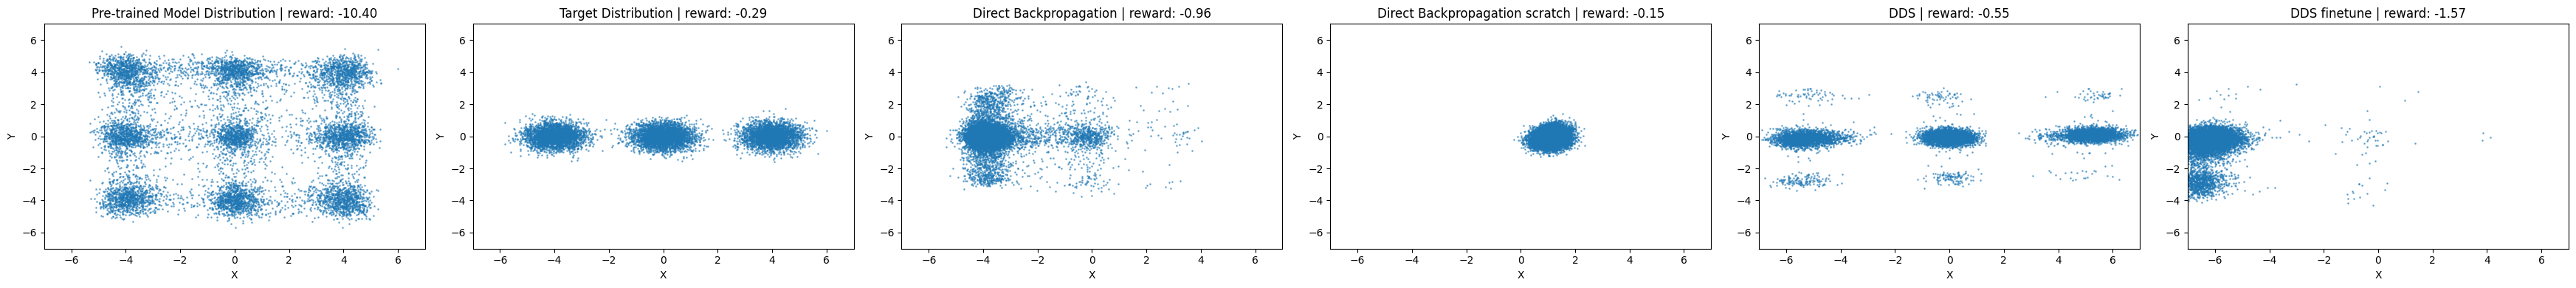

Figure saved as 'gaussian_mixture_dds_1.png'


In [24]:
# Plot results
plt.figure(figsize=(35, 4))

# Set common axis limits
x_min, x_max = -7, 7
y_min, y_max = -7, 7

plt.subplot(1, 6, 1)
plt.scatter(pre_trained_samples[:, 0], pre_trained_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Pre-trained Model Distribution | reward: {pre_trained_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 2)
plt.scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Target Distribution | reward: {target_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 3)
plt.scatter(backprop_samples[:, 0], backprop_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Direct Backpropagation | reward: {backprop_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 4)
plt.scatter(backprop_scratch_samples[:, 0], backprop_scratch_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Direct Backpropagation scratch | reward: {backprop_scratch_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 5)
plt.scatter(DDS_samples[:, 0], DDS_samples[:, 1], alpha=0.5, s=1)
plt.title(f'DDS | reward: {DDS_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 6)
plt.scatter(DDS_finetune_samples[:, 0], DDS_finetune_samples[:, 1], alpha=0.5, s=1)
plt.title(f'DDS finetune | reward: {DDS_finetune_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()

# Save the figure
plt.savefig('gaussian_mixture_dds_1.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

print("Figure saved as 'gaussian_mixture_dds_1.png'")

In [25]:
from scipy.stats import wasserstein_distance_nd as WD
from numpy.random import choice

backprop_emd = WD(backprop_samples[choice(np.arange(len(backprop_samples)), 500)], target_samples[choice(np.arange(len(target_samples)), 500)])
backprop_scratch_emd = WD(backprop_scratch_samples[choice(np.arange(len(backprop_scratch_samples)), 500)], target_samples[choice(np.arange(len(target_samples)), 500)])
DDS_emd = WD(DDS_samples[choice(np.arange(len(DDS_samples)), 500)], target_samples[choice(np.arange(len(target_samples)), 500)])
DDS_finetune_emd = WD(DDS_finetune_samples[choice(np.arange(len(DDS_finetune_samples)), 500)], target_samples[choice(np.arange(len(target_samples)), 500)])